In [11]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Initialize dictionary to hold data
# df = {}
# activities = ['laying', 'sitting', 'standing', 'walking', 'walking_downstairs', 'walking_upstairs']

# # Load data for each activity into the dictionary
# for activity in activities:
#     df[activity] = pd.read_csv(f"data+scripts/Combined/Train/{activity.upper()}/Subject_1.csv")

# # Create subplots to visualize waveforms
# fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharey=True)

# for i, activity in enumerate(activities):
#     # Plot the waveform for each activity
#     axes[i].plot(df[activity].iloc[:, 0])  # Assuming waveform data is in the first column
#     axes[i].set_title(activity)
#     axes[i].set_xlabel('Time')
#     if i == 0:
#         axes[i].set_ylabel('Amplitude')

# plt.tight_layout()
# plt.show()


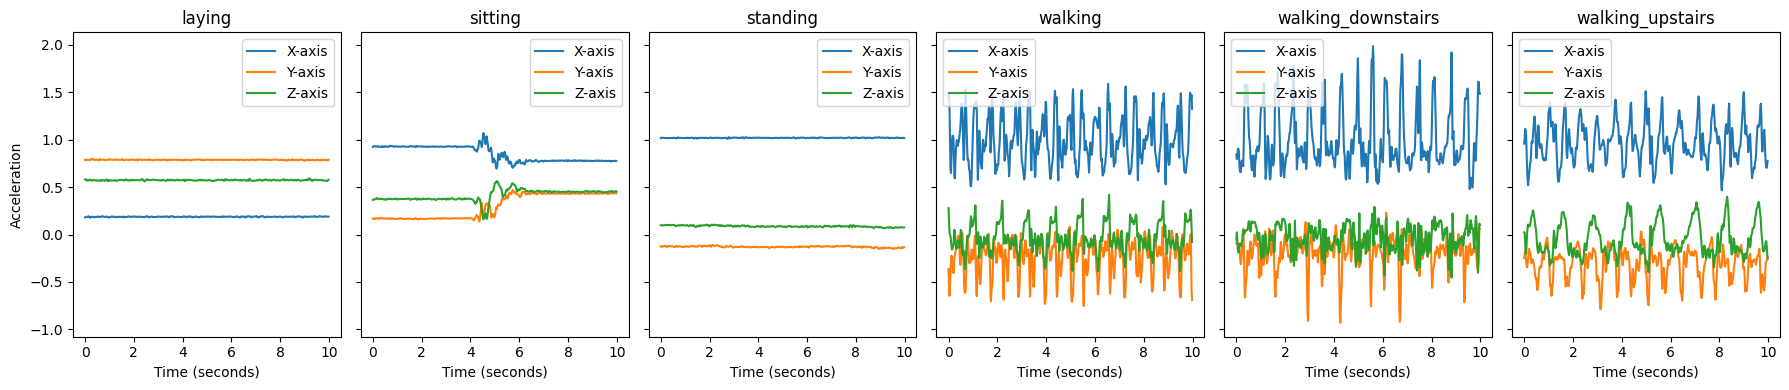

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize dictionary to hold data
df = {}
activities = ['laying', 'sitting', 'standing', 'walking', 'walking_downstairs', 'walking_upstairs']

# Load data for each activity into the dictionary
for activity in activities:
    df[activity] = pd.read_csv(f"data+scripts/Combined/Train/{activity.upper()}/Subject_1.csv")

# Create subplots to visualize waveforms
fig, axes = plt.subplots(1, 6, figsize=(18, 4), sharey=True)

# Define the number of samples to plot (corresponding to 10 seconds at 50Hz)
num_samples = 500
sampling_rate = 50  # 50Hz

for i, activity in enumerate(activities):
    # Extract the first 500 samples for each activity
    data = df[activity].iloc[:num_samples]
    # Extract x, y, z components
    x = data.iloc[:, 0]
    y = data.iloc[:, 1]
    z = data.iloc[:, 2]

    # Create time axis in seconds
    time = range(num_samples)  # 0 to 499 samples
    time_seconds = [t / sampling_rate for t in time]  # Convert samples to seconds

    # Plot the waveform for each activity
    axes[i].plot(time_seconds, x, label='X-axis')
    axes[i].plot(time_seconds, y, label='Y-axis')
    axes[i].plot(time_seconds, z, label='Z-axis')
    axes[i].set_title(activity)
    axes[i].set_xlabel('Time (seconds)')
    if i == 0:
        axes[i].set_ylabel('Acceleration')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [1]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import StandardScaler

# # Initialize dictionary to hold data
# df = {}
# activities = ['laying', 'sitting', 'standing', 'walking', 'walking_downstairs', 'walking_upstairs']

# # Load data for each activity into the dictionary
# for activity in activities:
#     df[activity] = pd.read_csv(f"data+scripts/Combined/Train/{activity.upper()}/Subject_1.csv")

# # Prepare data for plotting Total Acceleration
# total_acceleration = []
# activity_labels = []

# for activity in activities:
#     x = df[activity].iloc[:, 0]
#     y = df[activity].iloc[:, 1]
#     z = df[activity].iloc[:, 2]
#     total_acc = np.sqrt(x**2 + y**2 + z**2)
    
#     total_acceleration.append(total_acc)
#     activity_labels.extend([activity] * len(total_acc))

# # Combine the total acceleration data into a single array
# total_acceleration = np.concatenate(total_acceleration).reshape(-1, 1)

# # Standardize the data
# scaler = StandardScaler()
# total_acceleration = scaler.fit_transform(total_acceleration)

# # Scatter plot for Total Acceleration
# plt.figure(figsize=(10, 6))
# for activity in activities:
#     activity_total_acc = total_acceleration[np.array(activity_labels) == activity]
#     plt.scatter(np.arange(len(activity_total_acc)), activity_total_acc, label=activity, alpha=0.6)

# plt.title('Total Acceleration without PCA')
# plt.xlabel('Time')
# plt.ylabel('Total Acceleration (Standardized)')
# plt.legend()
# plt.show()


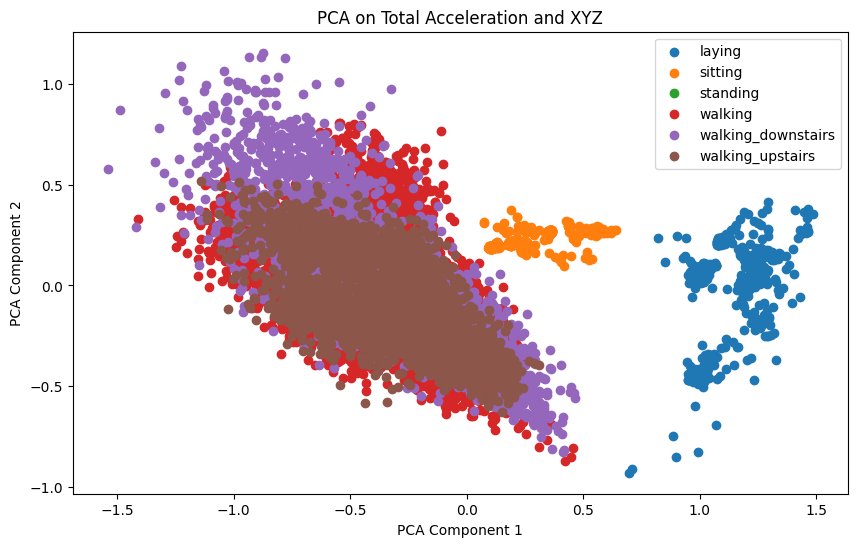

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

all_data = []
labels = []

for activity in activities:
    # Check the column names from the print statement and update accordingly
    data = df[activity]  # Assuming the first three columns are acceleration components
    all_data.append(data)
    labels += [activity] * len(data)

# Concatenate all the data into one DataFrame
all_data = pd.concat(all_data)
labels = np.array(labels)

# Calculate total acceleration assuming columns 0, 1, 2 are x, y, z components
all_data['total_acceleration'] = np.sqrt(all_data.iloc[:, 0]**2 + all_data.iloc[:, 1]**2 + all_data.iloc[:, 2]**2)

# Ensure the column names match the actual ones
# Replace 'acc_x', 'acc_y', 'acc_z' with actual column names if different
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_data.iloc[:, :4])  # Use the correct range of columns

# Scatter plot of the PCA result
plt.figure(figsize=(10, 6))
for activity in activities:
    activity_indices = labels == activity
    plt.scatter(pca_result[activity_indices, 0], pca_result[activity_indices, 1], label=activity)

plt.title('PCA on Total Acceleration and XYZ')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [10]:
# Make sure labels and pca_tsfel_result have the same length
print(f"Length of labels: {len(labels)}")
print(f"Shape of PCA result: {pca_tsfel_result.shape}")

Length of labels: 22208
Shape of PCA result: (6, 2)


In [12]:
import tsfel
from sklearn.preprocessing import StandardScaler

# Extract features using TSFEL
features_data = []

for activity in activities:
    # Extract features from each axis ('accx', 'accy', 'accz')
    data = df[activity][['accx', 'accy', 'accz']]
    features = tsfel.time_series_features_extractor(tsfel.get_features_by_domain(), data, verbose=0)
    features_data.append(features)

# Combine the extracted features into one DataFrame
features_data = pd.concat(features_data, ignore_index=True)

# Remove columns with NaN or constant values to avoid PCA errors
features_data = features_data.dropna(axis=1).loc[:, (features_data != features_data.iloc[0]).any()]

# Standardize the features for PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_data)

# Apply PCA on the extracted features
pca_tsfel = PCA(n_components=2)
pca_tsfel_result = pca_tsfel.fit_transform(features_scaled)

# Scatter plot of the PCA result using TSFEL features
plt.figure(figsize=(10, 6))
for activity in activities:
    activity_indices = labels == activity
    plt.scatter(pca_tsfel_result[activity_indices, 0], pca_tsfel_result[activity_indices, 1], label=activity)

plt.title('PCA on TSFEL Extracted Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


C:\Users\SIDDHARTH\AppData\Local\Temp\ipykernel_16200\584734753.py:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(tsfel.get_features_by_domain(), data, verbose=0)
C:\Users\SIDDHARTH\AppData\Local\Temp\ipykernel_16200\584734753.py:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(tsfel.get_features_by_domain(), data, verbose=0)
C:\Users\SIDDHARTH\AppData\Local\Temp\ipykernel_16200\584734753.py:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(tsfel.get_features_by_domain(), data, verbose=0)
C:\Users\SIDDHARTH\AppData\Local\Temp\ipykernel_16200\584734753.py:10: UserWarning: Using default sampling frequency set in configuration file.
  features = tsfel.time_series_features_extractor(tsfel.get_features_by_domain(), data, verbose=0)
C:\Users\SIDDHARTH\AppData\L

IndexError: boolean index did not match indexed array along axis 0; size of axis is 6 but size of corresponding boolean axis is 22208

<Figure size 1000x600 with 0 Axes>